<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1">Import</a></span></li><li><span><a href="#1.-Анализ-датасета" data-toc-modified-id="1.-Анализ-датасета-2">1. Анализ датасета</a></span><ul class="toc-item"><li><span><a href="#1.1-Описание-признаков" data-toc-modified-id="1.1-Описание-признаков-2.1">1.1 Описание признаков</a></span></li><li><span><a href="#1.2-Считывание-датасета" data-toc-modified-id="1.2-Считывание-датасета-2.2">1.2 Считывание датасета</a></span></li><li><span><a href="#1.3-EDA" data-toc-modified-id="1.3-EDA-2.3">1.3 EDA</a></span></li><li><span><a href="#2.-Изменение-датасета" data-toc-modified-id="2.-Изменение-датасета-2.4">2. Изменение датасета</a></span></li></ul></li></ul></div>

# Import

In [1]:
import pandas as pd, numpy as np, re, scipy.stats as stats
import seaborn as sns, matplotlib.pyplot as plt, plotly.express as px
from collections import Counter
from tqdm import tqdm, tqdm_notebook


from sklearn import decomposition
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectPercentile
from mlxtend.feature_selection import SequentialFeatureSelector

from datetime import datetime
import time

import warnings
warnings.filterwarnings('ignore')

# 1. Анализ датасета

## 1.1 Описание признаков

TCS_CUSTOMER_ID	Идентификатор клиента	ID

BUREAU_CD	Код бюро, из которого получен счет	numeric

BKI_REQUEST_DATE	Дата, в которую был сделан запрос в бюро	date

CURRENCY	Валюта договора (ISO буквенный код валюты)	string

RELATIONSHIP	Тип отношения к договору	string
	1 - Физическое лицо	
	2 - Дополнительная карта/Авторизованный пользователь	
	4 - Совместный 	
	5 - Поручитель	
	9 - Юридическое лицо	
    
OPEN_DATE	Дата открытия договора	date

FINAL_PMT_DATE	Дата финального платежа (плановая)	date

TYPE	Код типа договора	string
	1 – Кредит на автомобиль	
	4 – Лизинг. Срочные платежи за наем/пользование транспортным средством, предприятием или оборудованием и т.п.	
	6 – Ипотека – ссудные счета, имеющие отношение к домам, квартирам и прочей недвижимости. Ссуда выплачивается циклично согласно договоренности до тех пор, пока она не будет полностью выплачена или возобновлена. 	
	7 – Кредитная карта 	
	9 – Потребительский кредит	
	10 – Кредит на развитие бизнеса	
	11 – Кредит на пополнение оборотных средств	
	12 – Кредит на покупку оборудования 	
	13 – Кредит на строительство недвижимости	
	14 – Кредит на покупку акций (например, маржинальное кредитование)	
	99 – Другой	
    
PMT_STRING_84M	Дисциплина (своевременность) платежей. Строка составляется из кодов состояний счета на моменты передачи банком данных по счету в бюро, первый символ - состояние на дату PMT_STRING_START, далее последовательно в порядке убывания дат.	string
	0 – Новый, оценка невозможна	
	X – Нет информации	
	1 – Оплата без просрочек	
	A – Просрочка от 1 до 29 дней	
	2 – Просрочка от 30 до 59 дней	
	3 – Просрочка от 60 до 89 дней	
	4 – Просрочка от 90 до 119 дней	
	5 – Просрочка более 120 дней	
	7 – Регулярные консолидированные платежи	
	8 – Погашение по кредиту с использованием залога	
	9 – Безнадёжный долг/ передано на взыскание/ пропущенный платеж	
    
STATUS	Статус договора	string
	00 – Активный	
	12 – Оплачен за счет обеспечения	
	13 – Счет закрыт	
	14 – Передан на обслуживание в другой банк	
	21 – Спор	
	52 – Просрочен	
	61 – Проблемы с возвратом	
    
OUTSTANDING	Оставшаяся непогашенная задолженность. Сумма в рублях по курсу ЦБ РФ	numeric

NEXT_PMT	Размер следующего платежа. Сумма в рублях по курсу ЦБ РФ	numeric

INF_CONFIRM_DATE	Дата подтверждения информации по счету	date

FACT_CLOSE_DATE	Дата закрытия счета (фактическая)	date

TTL_DELQ_5	Количество просрочек до 5 дней	numeric

TTL_DELQ_5_29	Количество просрочек от 5 до 29 дней	numeric

TTL_DELQ_30_59	Количество просрочек от 30 до 59 дней	numeric

TTL_DELQ_60_89	Количество просрочек от 60 до 89 дней	numeric

TTL_DELQ_30	Количество просрочек до 30 дней	numeric

TTL_DELQ_90_PLUS	Количество просрочек 90+ дней	numeric

PMT_FREQ	Код частоты платежей	string
	1 – Еженедельно	
	2 – Раз в две недели	
	3 – Ежемесячно	
	A - Раз в 2 месяца	
	4 – Поквартально	
	B - Раз в 4 месяца	
	5 – Раз в полгода	
	6 -  Ежегодно	
	7 – Другое	
    
CREDIT_LIMIT	Кредитный лимит. Сумма в рублях по курсу ЦБ РФ	numeric

DELQ_BALANCE	Текущая просроченная задолженность. Сумма в рублях по курсу ЦБ РФ	numeric

MAX_DELQ_BALANCE	Максимальный объем просроченной задолженности. Сумма в рублях по курсу ЦБ РФ	numeric

CURRENT_DELQ	Текущее количество дней просрочки	numeric

PMT_STRING_START	Дата начала строки PMT_STRING_84M	date

INTEREST_RATE	Процентная ставка по кредиту	numeric

CURR_BALANCE_AMT	Общая выплаченная сумма, включая сумму основного долга, проценты, пени и штрафы. Сумма в рублях по курсу ЦБ РФ	numeric

## 1.2 Считывание датасета

In [52]:
# функция для преобразования дат (int -> datetime)
def get_time(time):
    if type(int(str(time)))==int:
        seconds = (int(time) - 25569) * 86400
        temp = datetime.utcfromtimestamp(seconds)
        return temp
        
    elif type(time.astype('int')) == np.int32 or numpy.int64:
        seconds = (int(time) - 25569) * 86400
        temp = datetime.utcfromtimestamp(seconds)
        return temp
    
    else:
        return np.nan

vget_time = np.vectorize(get_time)

# функция для поиска количества повторений
def count_freq(df: pd.DataFrame, type_to_count: 'str') -> pd.DataFrame:

    freq_df = pd.DataFrame(
        columns=[f'{type_to_count.upper()}_freq_type_{ttype}' for ttype in set(df[type_to_count])],
        index=pd.Index(set(df['tcs_customer_id']))
    ).fillna(0)

    temp_df = df[['tcs_customer_id', type_to_count]]
    for _, tcs_id in enumerate(tqdm_notebook(set(temp_df['tcs_customer_id']))):

        count_val = temp_df[temp_df['tcs_customer_id'] == tcs_id][type_to_count]
        dict_val = dict(Counter(count_val))

        for key in dict_val.keys():
            freq_df.loc[tcs_id, f'{type_to_count.upper()}_freq_type_{key}'] = dict_val.get(key)
                               
    return freq_df

In [57]:
# читаем датасет
df_read = pd.read_csv('new/SAMPLE_ACCOUNTS.csv', sep=';', decimal=',',
                dtype={'pmt_freq': str, 'fact_close_date':str})


id_accounts = pd.read_csv('SAMPLE_CUSTOMERS.csv', sep=';')
id_accounts.rename(columns={'bad':'default'}, inplace=True)

print('Размер датасета:', df_read.shape)
print('Количество заемщиков:', id_accounts.shape[0])

Размер датасета: (280942, 28)
Количество заемщиков: 50000


In [58]:
# у нас есть 2 таблицы - сам датасет и указание на train/test.
# объединим их в одну таблицу и удалим данные с пометкой test (потому что отсутствует таргет)

df = df_read.merge(id_accounts, how='left', on='tcs_customer_id')
df = df[df.sample_type == 'train'].drop('sample_type', axis=1).reset_index(drop=True)
df['default'] = df['default'].astype(int)

print(df.shape)
df.head()

(193338, 29)


,tcs_customer_id,bureau_cd,bki_request_date,inf_confirm_date,type,status,open_date,final_pmt_date,fact_close_date,credit_limit,...,ttl_delq_60_89,ttl_delq_90_plus,pmt_string_start,pmt_string_84m,delq_balance,max_delq_balance,interest_rate,pmt_freq,relationship,default
0,2,1,40665,40618,9,13,40472,40618.0,40618,7551,...,0,0,40617.0,11111,0.0,0.0,0,3,1,0
1,2,3,40665,40661,9,0,40652,40958.0,NaN,21186,...,0,0,40687.0,X1,0.0,0.0,0,3,1,0
2,2,3,40665,40661,9,13,40472,40618.0,40602,7551,...,0,0,40602.0,11111,0.0,0.0,0,3,1,0
3,3,2,40637,40609,7,0,40604,NaN,NaN,20000,...,0,0,40605.0,X1,0.0,0.0,0,7,1,1
4,3,1,40637,40069,9,13,39647,40068.0,40068,22694,...,0,0,40069.0,"1,11111E+13",0.0,0.0,0,3,1,1


## 1.3 EDA

In [4]:
df.columns # полученные колонки

Index(['tcs_customer_id', 'bureau_cd', 'bki_request_date', 'inf_confirm_date',
       'type', 'status', 'open_date', 'final_pmt_date', 'fact_close_date',
       'credit_limit', 'currency', 'outstanding', 'next_pmt',
       'curr_balance_amt', 'current_delq', 'ttl_delq_5', 'ttl_delq_5_29',
       'ttl_delq_30', 'ttl_delq_30_59', 'ttl_delq_60_89', 'ttl_delq_90_plus',
       'pmt_string_start', 'pmt_string_84m', 'delq_balance',
       'max_delq_balance', 'interest_rate', 'pmt_freq', 'relationship',
       'default'],
      dtype='object')

In [5]:
df.dtypes # типы колонок

tcs_customer_id       int64
bureau_cd             int64
bki_request_date      int64
inf_confirm_date      int64
type                  int64
status                int64
open_date             int64
final_pmt_date      float64
fact_close_date      object
credit_limit          int64
currency             object
outstanding         float64
next_pmt            float64
curr_balance_amt    float64
current_delq        float64
ttl_delq_5            int64
ttl_delq_5_29         int64
ttl_delq_30           int64
ttl_delq_30_59        int64
ttl_delq_60_89        int64
ttl_delq_90_plus      int64
pmt_string_start    float64
pmt_string_84m       object
delq_balance        float64
max_delq_balance    float64
interest_rate         int64
pmt_freq             object
relationship          int64
default               int32
dtype: object

In [6]:
null_count = pd.DataFrame(data = zip(df.isna().sum(), df.isna().sum().values/len(df)), 
                          columns=['Number of NaN', '% of NaN'], 
                          index=pd.Index(df.columns)) \
                          .sort_values(by='% of NaN', ascending=False)


# Таблица с количеством пропусков и % пропусков от числа строк
null_count.head(12)

,Number of NaN,% of NaN
curr_balance_amt,122814,0.635229
next_pmt,105528,0.545821
fact_close_date,98574,0.509853
outstanding,37368,0.193278
current_delq,36681,0.189725
final_pmt_date,12610,0.065223
pmt_string_start,11015,0.056973
pmt_string_84m,6255,0.032353
pmt_freq,145,0.000750
max_delq_balance,19,0.000098


In [7]:
# уберем колонки с пропуском более 18%
df.drop(null_count.index[:5], axis=1, inplace=True)

# удалим пустые значения, где их мало
df.dropna(subset=['pmt_freq', 'max_delq_balance', 'delq_balance'], axis=0, inplace=True)

# также удалим некоторые даты и признак, который дублируется
df.drop(['final_pmt_date', 'pmt_string_start', 'pmt_string_84m'], axis=1, inplace=True)

print('Размер датасета после удаления стобцов и пустых значений: ', df.shape)

Размер датасета после удаления стобцов и пустых значений:  (193174, 21)


In [8]:
df.select_dtypes('int64').head(3) # числовые колонки

,tcs_customer_id,bureau_cd,bki_request_date,inf_confirm_date,type,status,open_date,credit_limit,ttl_delq_5,ttl_delq_5_29,ttl_delq_30,ttl_delq_30_59,ttl_delq_60_89,ttl_delq_90_plus,interest_rate,relationship
0,2,1,40665,40618,9,13,40472,7551,0,0,0,0,0,0,0,1
1,2,3,40665,40661,9,0,40652,21186,0,0,0,0,0,0,0,1
2,2,3,40665,40661,9,13,40472,7551,0,0,0,0,0,0,0,1


In [9]:
df.select_dtypes('object').head(2) # колонки с категориальными признаками

,currency,pmt_freq
0,RUB,3
1,RUB,3


In [10]:
df[['bki_request_date', 'inf_confirm_date', 'open_date']].head(2)  # колонки, которые должны быть в формате дат

,bki_request_date,inf_confirm_date,open_date
0,40665,40618,40472
1,40665,40661,40652


In [11]:
print('columns count of int columns - ', df.select_dtypes('int').shape[1])
print('columns count of object columns - ', df.select_dtypes('object').shape[1])
print('columns count of datetime columns - ', df[['bki_request_date', 'inf_confirm_date', 
                                                  'open_date']].shape[1])

columns count of int columns -  17
columns count of object columns -  2
columns count of datetime columns -  3


In [12]:
df.columns

Index(['tcs_customer_id', 'bureau_cd', 'bki_request_date', 'inf_confirm_date',
       'type', 'status', 'open_date', 'credit_limit', 'currency', 'ttl_delq_5',
       'ttl_delq_5_29', 'ttl_delq_30', 'ttl_delq_30_59', 'ttl_delq_60_89',
       'ttl_delq_90_plus', 'delq_balance', 'max_delq_balance', 'interest_rate',
       'pmt_freq', 'relationship', 'default'],
      dtype='object')

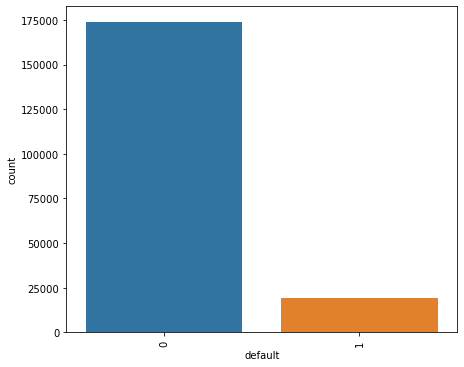

0    173948
1     19226
Name: default, dtype: int64

In [13]:
# распределение таргета

plt.figure(figsize=(7, 6))
sns.countplot(x='default', data=df)
plt.xticks(rotation=90)
plt.show()

df['default'].value_counts()

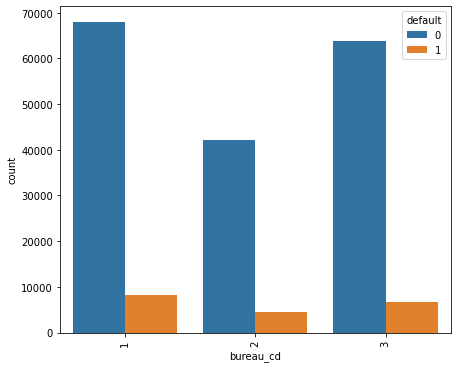

default
0    173948
1     19226
Name: bureau_cd, dtype: int64

In [14]:
plt.figure(figsize=(7, 6))
sns.countplot(x='bureau_cd', data=df, hue='default')
plt.xticks(rotation=90)
plt.show()

# соотношение бюро и заемщика
# в бюро 2 меньше
df.groupby('default')['bureau_cd'].count()

In [15]:
df_bureau_cd = pd.DataFrame(df.groupby(['bureau_cd', 'default'])['bureau_cd'].count())
df_bureau_cd.rename(columns={'bureau_cd':'requests'}, inplace=True)
df_bureau_cd['%'] = df_bureau_cd['requests'] / df_bureau_cd.groupby('bureau_cd')['requests'].transform('sum')

df_bureau_cd

# примерно одинаковое соотношение дефолта в каждом бюро - 90 на 10,
# в первом чуть больше дефолтов (1)

requests         %
bureau_cd default                    
1         0           68009  0.892518
          1            8190  0.107482
2         0           42204  0.905374
          1            4411  0.094626
3         0           63735  0.905841
          1            6625  0.094159

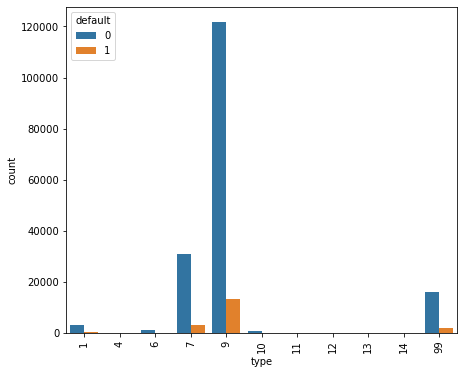

In [16]:
plt.figure(figsize=(7, 6))
sns.countplot(x=df.type.astype('category'), data=df, hue='default')
plt.xticks(rotation=90)
plt.show()

# больше всего кредитов на категории 9, 7, 99 - это "потребительский кредит", "кредитная карта" и
# "другое"

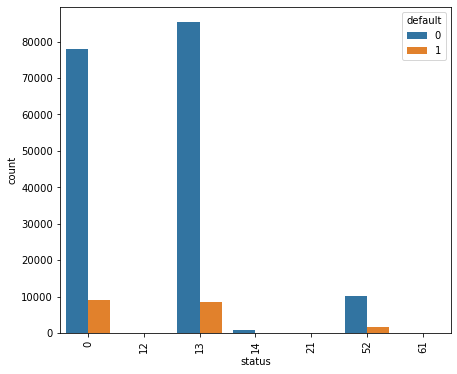

In [17]:
plt.figure(figsize=(7, 6))
sns.countplot(x=df.status.astype('category'), data=df, hue='default')
plt.xticks(rotation=90)
plt.show()

# по статусу договора - 13 "счет закрыт", 0 "активный", 52 "просрочен"

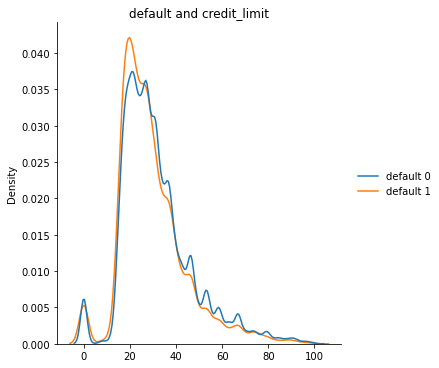

In [18]:
temp = df.query('credit_limit<1000_000')

sns.displot({'default 0': np.cbrt(temp[temp.default==0].credit_limit),
              'default 1': np.cbrt(temp[temp.default==1].credit_limit)}, kind='kde', common_norm=False)

plt.title('default and credit_limit') 
plt.show()

# в целом одинаковая пропорция по кредитному лимиту

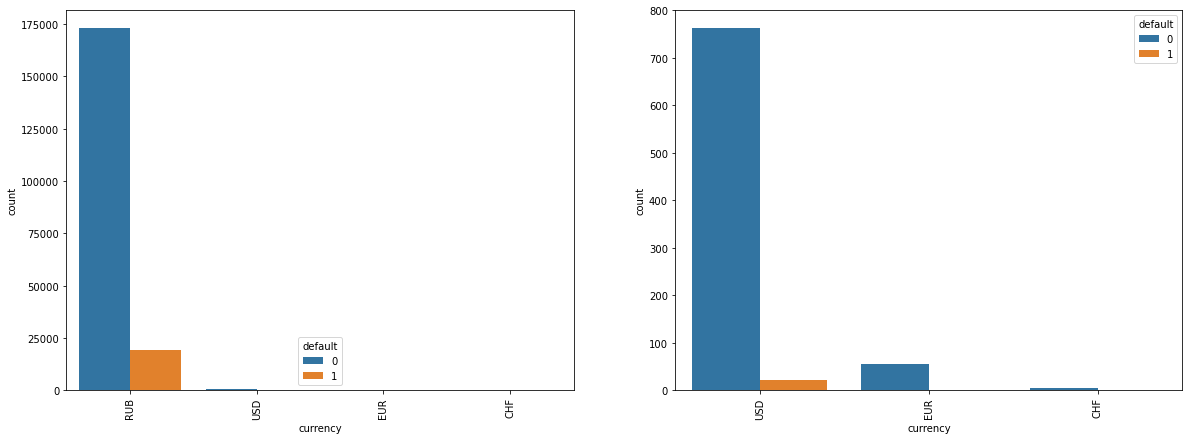

Виды валют: Counter({'RUB': 192328, 'USD': 785, 'EUR': 55, 'CHF': 6})


In [19]:
plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
sns.countplot(x='currency', data=df, hue='default')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
temp2 = df.query('currency!="RUB"')
sns.countplot(x='currency', data=temp2, hue='default')
plt.xticks(rotation=90)
plt.show()

print('Виды валют:', Counter(df.currency))
# суммы в датасете указаны в рублях, поэтому делать конвертацию не требуется

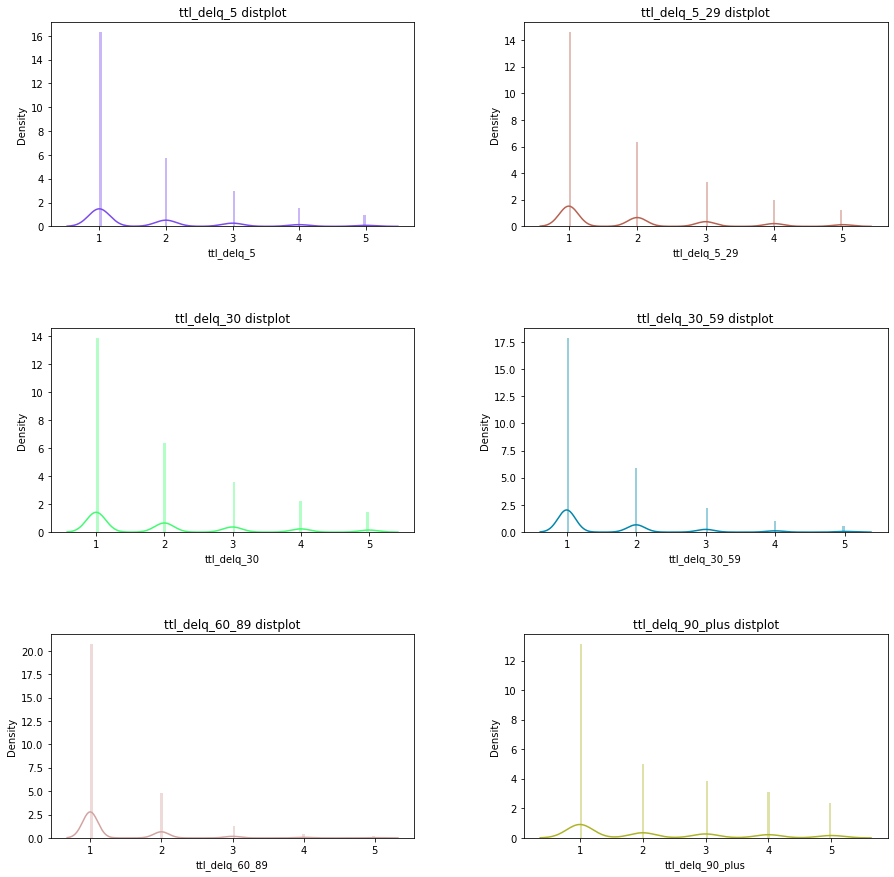

In [87]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

cols = ['ttl_delq_5', 'ttl_delq_5_29', 'ttl_delq_30', 'ttl_delq_30_59', 
        'ttl_delq_60_89', 'ttl_delq_90_plus']


ncols = 2
nrows = len(cols) // ncols + (len(cols) % ncols > 0)

for ind, col in enumerate(cols):
    
    temp = df.query(f'0 < {col} <= 5')
    ax = plt.subplot(nrows, ncols, ind + 1)
    sns.distplot(temp[col], bins=110, color = (np.random.random(), np.random.random(), np.random.random()))
    plt.title(f'{col} distplot')

plt.show()

# распределения по количеству просрочек
# 

<AxesSubplot:xlabel='interest_rate'>

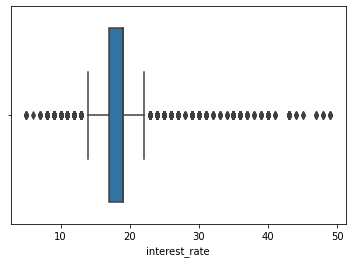

In [265]:
# в колонке процентной ставки много строк с 0% и 50+%
# если ограничить interest_rate, то больинство ставок будет 18-20%
sns.boxplot(df.query('0<interest_rate<50').interest_rate)

<AxesSubplot:xlabel='interest_rate'>

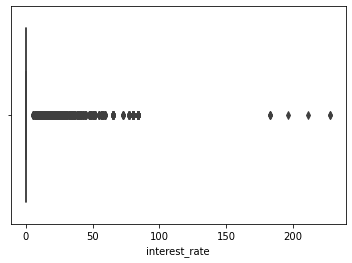

In [21]:
sns.boxplot(df.query('0<=interest_rate').interest_rate)
# ставка в 0% - скорее всего обычный пропуск или акция, например, 0% на первый месяц
# ставки больше 50% тоже не корректны

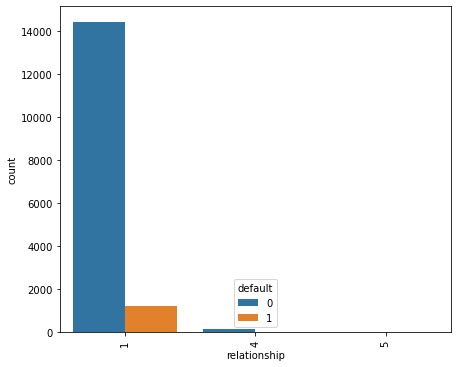

Counter({1: 15680, 4: 193, 5: 1})


In [81]:
plt.figure(figsize=(7, 6))
sns.countplot(x=df.relationship.astype('category'), data=df, hue='default')
plt.xticks(rotation=90)
plt.show()

print(Counter(df.relationship.astype('category')))
# по статусу договора - 13 "счет закрыт", 0 "активный", 52 "просрочен"

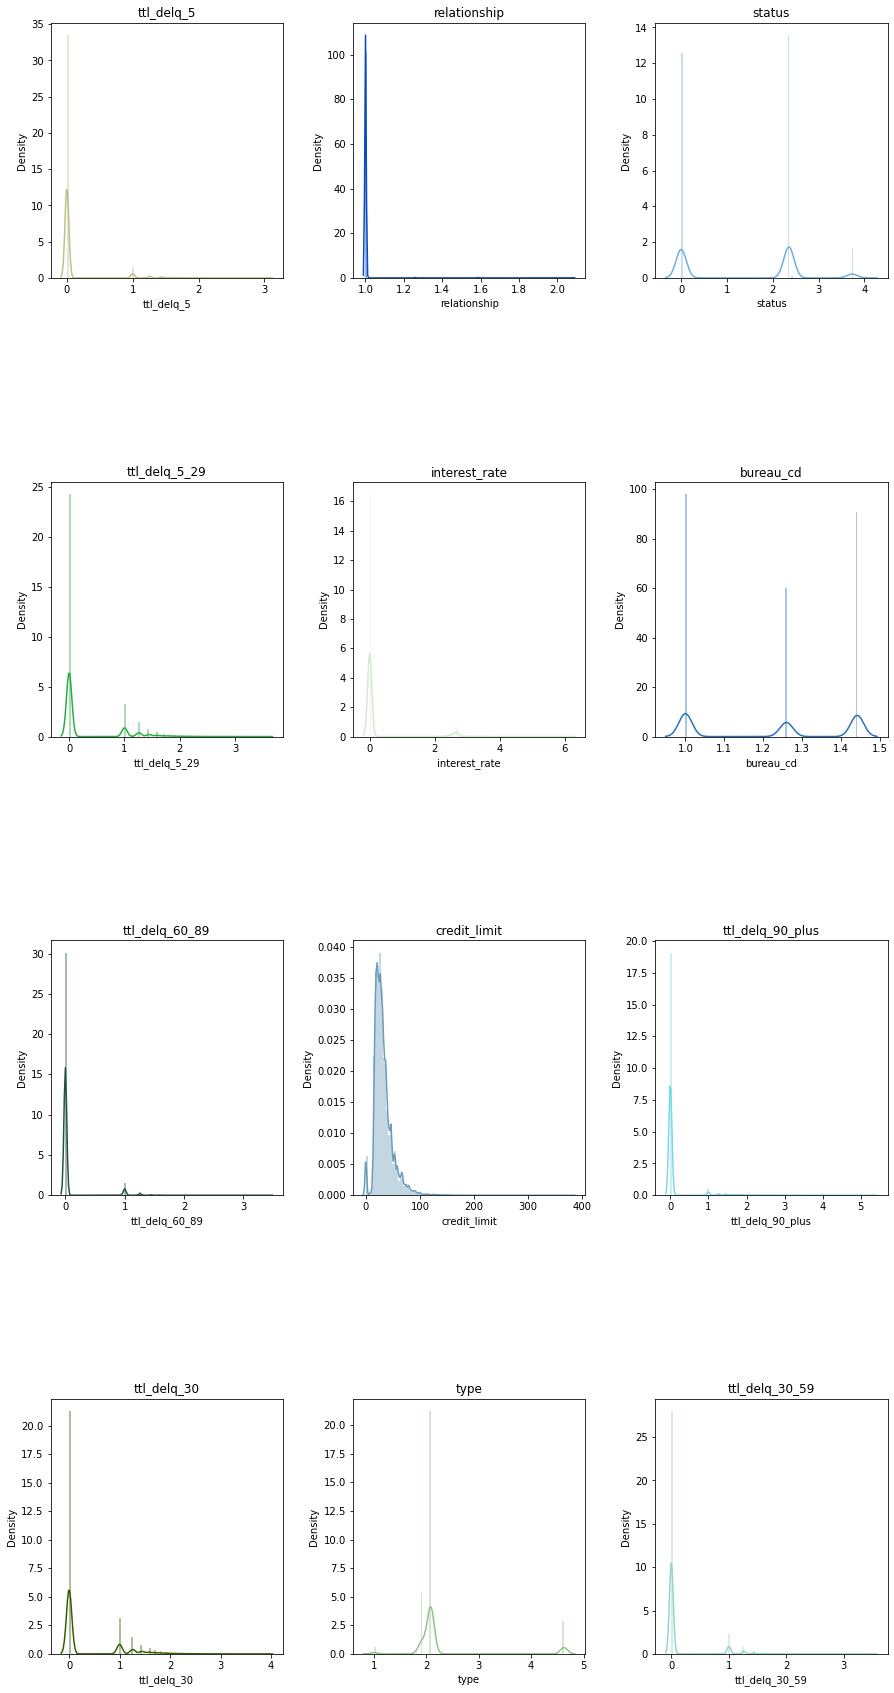

In [47]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

cols_all = df.drop('tcs_customer_id', axis=1).select_dtypes('int64').iloc[:, :18].columns.to_list()

cols_inds = [col for ind, col in enumerate(cols_all) if re.search('date', col.lower())]

cols = list(set(cols_all).symmetric_difference(set(cols_inds)))

ncols = 3
nrows = len(cols) // ncols + (len(cols) % ncols > 0)

for ind, col in enumerate(cols):
    ax = plt.subplot(nrows, ncols, ind + 1)

    sns.distplot(np.cbrt(df[col]), bins=110, color = (np.random.random(), np.random.random(), np.random.random()))
    plt.title(col)

plt.show()

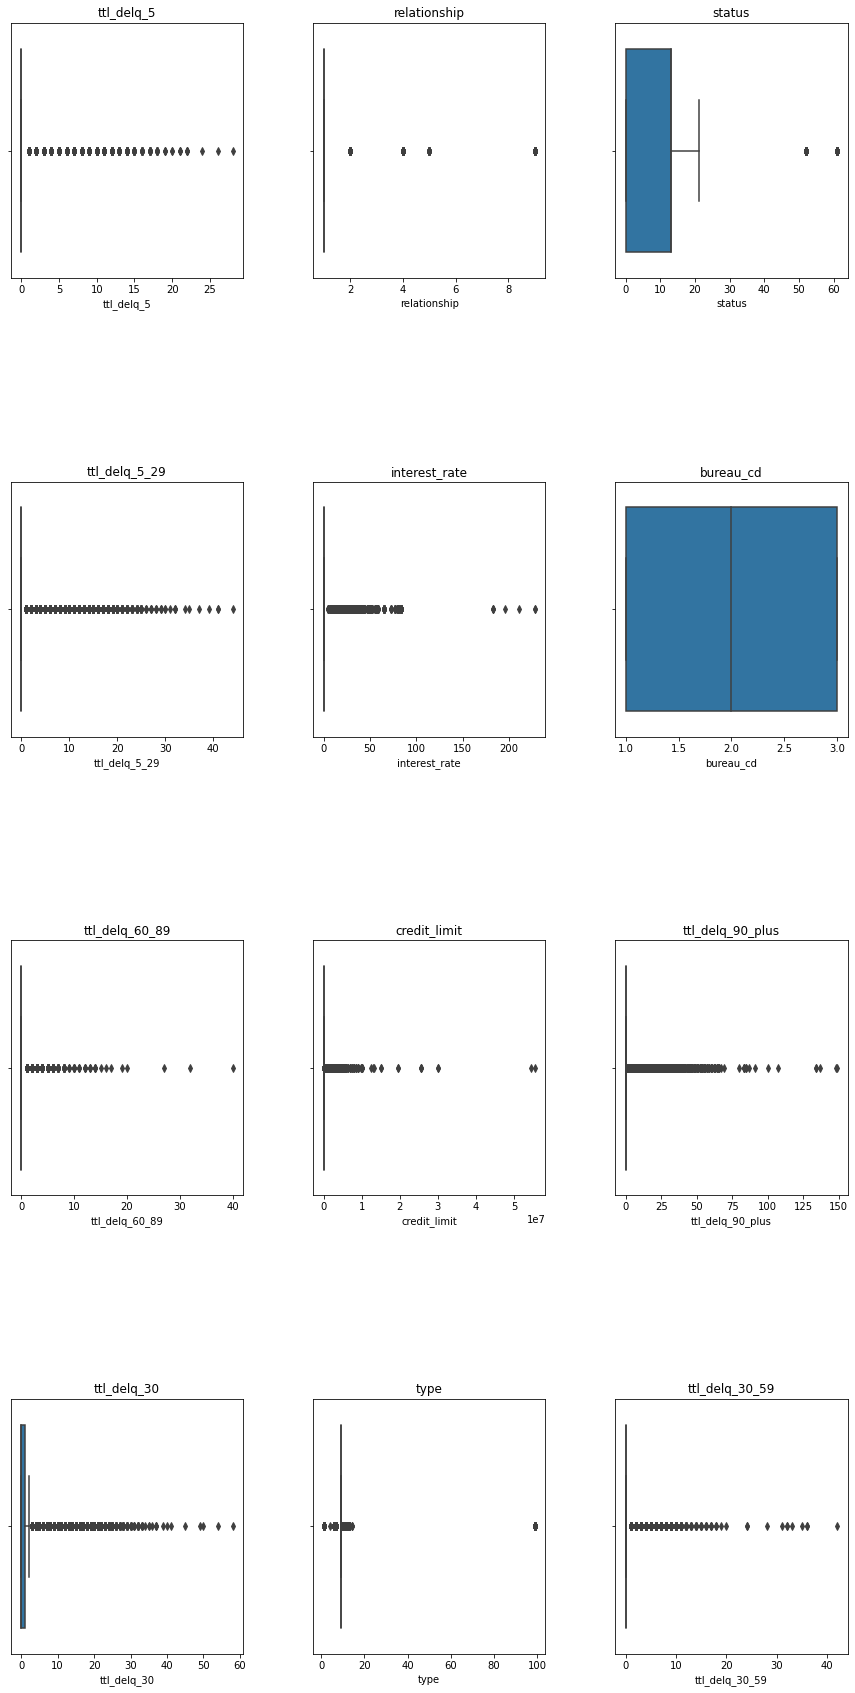

In [48]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

cols_all = df.drop('tcs_customer_id', axis=1).select_dtypes('int64').iloc[:, :18].columns.to_list()

cols_inds = [col for ind, col in enumerate(cols_all) if re.search('date', col.lower())]

cols = list(set(cols_all).symmetric_difference(set(cols_inds)))

ncols = 3
nrows = len(cols) // ncols + (len(cols) % ncols > 0)

for ind, col in enumerate(cols):
    ax = plt.subplot(nrows, ncols, ind + 1)

    sns.boxplot(x=df[col])
    plt.title(col)

plt.show()

## 2. Изменение датасета

В датасете несколько строк может относиться к одному клиенту. Для того, чтобы предсказать именно дефолт клиента, а не один взятый кредит (строка), требуется переделать датасет по-другому:

**Модель нового датасета:**
* Каждого клиента переводим в кластер (делаем группу клиентов), обобщая его прошлые кредиты
* Для колонки в старом датасете создаем новую, сгрупированную по ID клиента


**Пример (примерно такого вида датасет):**

|id |  credit_limit | interest_rate | status | default|
|:--|--------------:|--------------:|-------:|-------:|
|1  |  10_000       | 10            | 99     | 0
|1  |  20_000       | 15 | 13 | 0
|2  |  100_000      | 20 | 1 | 1|

**Данные выше преобразуются в следующий формат:**

|id |  credit_limit | interest_rate | frequency_99 | frequency_13 | frequency_1 | default|
|:-|---------------:|--------------:|-------------:|-------------:|------------:|-------:|
1 | 15_000 | 12.5 | 1 | 1 | 0 | 0
2 | 100_000 | 20 | 0 | 0 | 1 | 1

В данном примере мы брали среднее по credit_limit и interest_rate. Для таких факторов, как status или type,
которые являются категориальными, была реализована функция, которая считает количество повторений и заносит их
в таблицу. frequency_99 - частота договора со статусом 99 у клиента с ID 1, то есть у клиента был всего один кредит
со статусом 99. Аналогично будут добавлены в новую таблицу такие факторы.


>
> Итоговый датасет будет следующим:
> * Для каждого категориального признака посчитаем его частоту у каждого клиента
> * Для числовых признаков добавим среднее, медиану, сумму (не для всех)
> * Для дат посчитаем кредитную историю - число дней, месяец и лет
> * После этого можно будет строить модели не для предсказания дефолта конкретного **счета**,
а для предсказания дефолта **клиента**

In [62]:
%%time
start_time = datetime.now()

print('0. Start creating df...', f' || TIME: {datetime.now() - start_time} \n')
df_res = pd.DataFrame(index=pd.Index(set(df.tcs_customer_id)))



print('1. Add status...', f' || TIME: {datetime.now() - start_time}')
status_freq_df = count_freq(df=df, type_to_count='status')
df_res = pd.concat([df_res, status_freq_df], axis=1)



print('2. Add type...', f' || TIME: {datetime.now() - start_time}')
type_freq_df = count_freq(df=df, type_to_count='type')
df_res = pd.concat([df_res, type_freq_df], axis=1)



print('3. Add bureau_cd...', f' || TIME: {datetime.now() - start_time} \n')
df_res['bureau_cd'] = df.groupby('tcs_customer_id')['bureau_cd'] \
                      .apply(lambda x: Counter(x).most_common()[0][0]) \
                      .astype(int)



print('4. Add mean/ median of credit_limit...', f' || TIME: {datetime.now() - start_time} \n')
df_res['credit_limit_mean'] = df[['tcs_customer_id', 'credit_limit']] \
                              .groupby('tcs_customer_id')['credit_limit'].mean()

df_res['credit_limit_median'] = df[['tcs_customer_id', 'credit_limit']] \
                                .groupby('tcs_customer_id')['credit_limit'].median()




print('5. Add default...', f' || TIME: {datetime.now() - start_time} \n')
df_res['default'] = df[['tcs_customer_id', 'default']] \
                    .groupby('tcs_customer_id')['default'].mean().astype(int)




print('6. Add relationship...', f' || TIME: {datetime.now() - start_time}')
relationship_freq_df = count_freq(df=df, type_to_count='relationship')
df_res = pd.concat([df_res, relationship_freq_df], axis=1)




print('7. Add mean/ median of interest_rate...', f' || TIME: {datetime.now() - start_time} \n')
df_res['interest_rate_mean'] = df[['tcs_customer_id', 'interest_rate']] \
                               .groupby('tcs_customer_id')['interest_rate'].mean()

df_res['interest_rate_median'] = df[['tcs_customer_id', 'interest_rate']] \
                                .groupby('tcs_customer_id')['interest_rate'].median()




print('8. Add mean/ median/ sum of all ttl_delq...', 
      f' || TIME: {datetime.now() - start_time} \n')
cols_ttl = ['ttl_delq_5', 'ttl_delq_5_29', 'ttl_delq_30', 'ttl_delq_30_59', 
            'ttl_delq_60_89', 'ttl_delq_90_plus']
for col in cols_ttl:
    df_res[col] = df[['tcs_customer_id', col]].groupby('tcs_customer_id')[col].sum()
    df_res[col+'_mean'] = df[['tcs_customer_id', col]].groupby('tcs_customer_id')[col].mean()
    df_res[col+'_sum'] = df[['tcs_customer_id', col]].groupby('tcs_customer_id')[col].median()

    
    
    
print('9. Add mean/ median/ sum of max_delq_balance...', f' || TIME: {datetime.now() - start_time} \n')    
df_res['max_delq_balance_mean'] = df[['tcs_customer_id', 'max_delq_balance']] \
                                  .groupby('tcs_customer_id')['max_delq_balance'].mean()
df_res['max_delq_balance_median'] = df[['tcs_customer_id', 'max_delq_balance']] \
                                    .groupby('tcs_customer_id')['max_delq_balance'].median()
df_res['max_delq_balance_sum'] = df[['tcs_customer_id', 'max_delq_balance']] \
                                 .groupby('tcs_customer_id')['max_delq_balance'].sum()
    
    
    
print('10. Add mean/ median/ sum of delq_balance...', f' || TIME: {datetime.now() - start_time} \n') 
df_res['delq_balance_mean'] = df[['tcs_customer_id', 'delq_balance']] \
                                  .groupby('tcs_customer_id')['delq_balance'].mean()
df_res['delq_balance_median'] = df[['tcs_customer_id', 'delq_balance']] \
                                    .groupby('tcs_customer_id')['delq_balance'].median()
df_res['delq_balance_sum'] = df[['tcs_customer_id', 'delq_balance']] \
                                 .groupby('tcs_customer_id')['delq_balance'].sum()    
    
    
    
print('10. Add dates...', f' || TIME: {datetime.now() - start_time} \n') 
dates = pd.DataFrame(df.groupby('tcs_customer_id')['open_date'].min().values, columns=['min'])
dates['max'] =  df.groupby('tcs_customer_id')['open_date'].max().values

dates['min'] = vget_time(dates['min'])
dates['max'] = vget_time(dates['max'])
dates['diff_days'] = (dates['max'] - dates['min']).dt.days

df_res['diff_days'] = dates['diff_days'].values
df_res['diff_year'] = (df_res['diff_days'] / 365).astype('int64')
df_res['diff_month'] = (df_res['diff_days'] / 30).astype('int64') 
    
    
    
    
print('11. Add mean/ median/ sum of curr_balance_amt...', f' || TIME: {datetime.now() - start_time} \n') 
df_res['curr_balance_amt_mean'] = df[['tcs_customer_id', 'curr_balance_amt']] \
                                  .groupby('tcs_customer_id')['curr_balance_amt'].mean()
df_res['curr_balance_amt_mean'].fillna(df_res['curr_balance_amt_mean'].mean(), inplace=True)

df_res['curr_balance_amt_median'] = df[['tcs_customer_id', 'curr_balance_amt']] \
                                    .groupby('tcs_customer_id')['curr_balance_amt'].median()
df_res['curr_balance_amt_median'].fillna(df_res['curr_balance_amt_median'].median(), inplace=True)

df_res['curr_balance_amt_sum'] = df[['tcs_customer_id', 'curr_balance_amt']] \
                                 .groupby('tcs_customer_id')['curr_balance_amt'].sum()      
    

print('\033[1m' + 'End! \n' + f'TOTAL TIME: {datetime.now() - start_time}' + '\033[0m')
print('====================================================== \n\n')

print('Count of default:', Counter(df_res.default))

print(f'Shape new df: {df_res.shape} \n')

0. Start creating df...  || TIME: 0:00:00 

1. Add status...  || TIME: 0:00:00.023912


  0%|          | 0/35031 [00:00<?, ?it/s]

2. Add type...  || TIME: 0:00:19.837999


  0%|          | 0/35031 [00:00<?, ?it/s]

3. Add bureau_cd...  || TIME: 0:00:39.905887 

4. Add mean/ median of credit_limit...  || TIME: 0:00:40.598035 

5. Add default...  || TIME: 0:00:40.620974 

6. Add relationship...  || TIME: 0:00:40.629950


  0%|          | 0/35031 [00:00<?, ?it/s]

7. Add mean/ median of interest_rate...  || TIME: 0:00:58.842355 

8. Add mean/ median/ sum of all ttl_delq...  || TIME: 0:00:58.864296 

9. Add mean/ median/ sum of max_delq_balance...  || TIME: 0:00:59.047783 

10. Add mean/ median/ sum of max_delq_balance...  || TIME: 0:00:59.079726 

10. Add dates...  || TIME: 0:00:59.109615 

11. Add mean/ median/ sum of curr_balance_amt...  || TIME: 0:00:59.185412 

End! 
TOTAL TIME: 0:00:59.219321


Count of default: Counter({0: 30733, 1: 4298})
Shape new df: (35031, 59) 

CPU times: total: 59.2 s
Wall time: 59.2 s


In [64]:
print(df_res.columns)
print('Количество колонок - ', len(df_res.columns))
print('Размер датасета - ', df_res.shape)
df_res

Index(['STATUS_freq_type_0', 'STATUS_freq_type_12', 'STATUS_freq_type_13',
       'STATUS_freq_type_14', 'STATUS_freq_type_52', 'STATUS_freq_type_21',
       'STATUS_freq_type_61', 'TYPE_freq_type_1', 'TYPE_freq_type_99',
       'TYPE_freq_type_4', 'TYPE_freq_type_6', 'TYPE_freq_type_7',
       'TYPE_freq_type_9', 'TYPE_freq_type_10', 'TYPE_freq_type_11',
       'TYPE_freq_type_12', 'TYPE_freq_type_13', 'TYPE_freq_type_14',
       'bureau_cd', 'credit_limit_mean', 'credit_limit_median', 'default',
       'RELATIONSHIP_freq_type_1', 'RELATIONSHIP_freq_type_2',
       'RELATIONSHIP_freq_type_4', 'RELATIONSHIP_freq_type_5',
       'RELATIONSHIP_freq_type_9', 'interest_rate_mean',
       'interest_rate_median', 'ttl_delq_5', 'ttl_delq_5_mean',
       'ttl_delq_5_sum', 'ttl_delq_5_29', 'ttl_delq_5_29_mean',
       'ttl_delq_5_29_sum', 'ttl_delq_30', 'ttl_delq_30_mean',
       'ttl_delq_30_sum', 'ttl_delq_30_59', 'ttl_delq_30_59_mean',
       'ttl_delq_30_59_sum', 'ttl_delq_60_89', 'ttl_delq

,STATUS_freq_type_0,STATUS_freq_type_12,STATUS_freq_type_13,STATUS_freq_type_14,STATUS_freq_type_52,STATUS_freq_type_21,STATUS_freq_type_61,TYPE_freq_type_1,TYPE_freq_type_99,TYPE_freq_type_4,...,max_delq_balance_sum,delq_balance_mean,delq_balance_median,delq_balance_sum,diff_days,diff_year,diff_month,curr_balance_amt_mean,curr_balance_amt_median,curr_balance_amt_sum
2,1,0,2,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,180,0,6,3870.000000,3870.0,7740.0
3,3,0,1,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,957,2,31,0.000000,0.0,0.0
4,6,0,9,0,0,0,0,0,1,0,...,27.00,0.0,0.0,0.0,1868,5,62,8111.833333,7258.0,48671.0
5,0,0,1,0,0,0,0,0,0,0,...,997.47,0.0,0.0,0.0,0,0,0,55681.049046,13926.0,0.0
6,1,0,5,0,0,0,0,0,0,0,...,6537.00,0.0,0.0,0.0,365,1,12,22704.000000,22704.0,45408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49989,5,0,1,0,0,0,0,0,0,0,...,2749.01,0.0,0.0,0.0,455,1,15,1804.500000,1804.5,3609.0
49995,1,0,1,0,4,0,0,0,0,0,...,18012.00,3002.0,3330.0,18012.0,1691,4,56,38792.000000,38792.0,38792.0
49996,3,0,6,0,0,0,0,0,0,0,...,39624.00,0.0,0.0,0.0,581,1,19,131799.000000,57826.0,395397.0
49997,1,0,0,0,0,0,0,0,0,0,...,0.00,0.0,0.0,0.0,0,0,0,11123.000000,11123.0,11123.0


In [71]:
# сохраняем новый датасет
df_res.to_csv('preprocessed_df.csv', sep=';', header=True, index=False)